# Image-to-Image

The provided code is a Python script for implementing an image generation task using the "Img2Img" model in stable diffusion.

In [ ]:
!pip install -Uq diffusers transformers fastcore fastdownload

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch
from diffusers import LMSDiscreteScheduler
from PIL import Image
from tqdm.auto import tqdm
from diffusers import AutoencoderKL, UNet2DConditionModel
import logging
from fastdownload import FastDownload
from pathlib import Path
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
from torchvision import transforms

if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()
logging.disable(logging.WARNING)

We need to load in the required libraries and set up the models.

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float16)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

Define the parameters.

In [ ]:
height = 512
width = 512
num_inference_steps =  70
guidance_scale = 7.5
batch_size = 1
beta_start,beta_end = 0.00085,0.012

In [ ]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

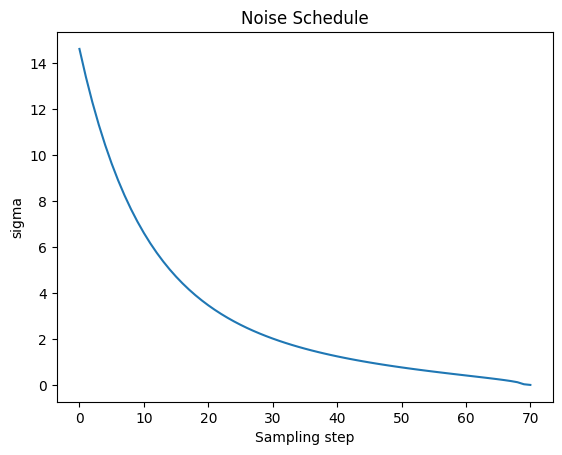

In [ ]:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

In [ ]:
def prep_img(img_link : str) -> torch.Tensor:
    """
    Preprocesses an image from a given link.

    Args:
        img_link (str): The URL or path to the image file.

    Returns:
        torch.Tensor: A tensor representing the preprocessed image.
    """
    
    p = FastDownload().download(img_link)
    init_image = Image.open(p).convert("RGB").resize((512, 512))
    return transforms.ToTensor()(init_image)

In [ ]:
#transformed_image = prep_img)("https://www.hellowonderful.co/wp-content/uploads/2017/10/1-scribble-monsters.jpg")
#transformed_image = prep_img("https://www.thespruce.com/thmb/NNXkysl23fSFExGyNtykPIayFlY=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/dog_body_language_whale_eye_118257_059-52bb447ffaa24d9b824ffda8aa216cfc.jpg")
transformed_image = prep_img("https://cdn-uploads.huggingface.co/production/uploads/1664665907257-noauth.png")

In [ ]:
def tokenization(prompt: list, max_len : int = None) - > torch.Tensor:
    """
    Tokenizes a text prompt and returns the corresponding encoded tensor.

    Args:
        prompt (list): The input text prompt to be tokenized.
        max_len (int, optional): The maximum length of the tokenized sequence. If not specified,
            it defaults to the maximum length allowed by the tokenizer.

    Returns:
        torch.Tensor: A tensor containing the encoded representation of the tokenized prompt.
    """

    if max_len is None : max_len = tokenizer.model_max_length
    
    tokenized_prompt = tokenizer(prompt, padding="max_length", max_length = max_len, truncation=True, return_tensors='pt')
    return text_encoder(tokenized_prompt.input_ids.to('cuda'))[0].half()

def make_image(latent: torch.Tensor):
    """
    Converts a tensor representation of an image into a PIL Image.

    Args:
        latent (torch.Tensor): A tensor representing an image.

    Returns:
        PIL.Image.Image: A PIL Image representing the image.
    """
    image = (latent/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

To ensure the effectiveness of this solution, it is essential to incorporate the "start_step" parameter.\
Essentially, we aim to prevent excessive noise from being added to the input image, particularly avoiding the most intense noise additions. \
After this initial step, we can proceed with the looping process.
>In summary, the key to success here is to introduce the "start_step" parameter, which helps us avoid excessive noise in the early stages and then continue with the loop as intended.

In [ ]:
def create_sample(prompt: list,transformed_image: torch.Tensor ,guidance_scale: float = 7.5, seed: int = 5, steps: int = 70,start_step: int = 10):
    """
    Generate a sample image based on a text prompt and guidance parameters.

    Args:
        prompt (list): A list of text prompts.
        transformed_image (torch.Tensor): A tensor representing the transformed image.
        guidance_scale (float, optional): The scale factor for guiding the generation process.
        seed (int, optional): Seed for random number generation. Default is 5.
        steps (int, optional): The total number of steps for the generation process. Default is 70.
        start_step (int, optional): The step at which the generation process starts. Default is 10.

    Returns:
        torch.Tensor: A tensor representing the generated sample.

    This function generates an image based on the provided text prompts , transformed image and parametrs.It uses a predefined
    VAE model to encode the image and then applies noise and guidance to generate the sample.It iteratively
    refines the image by adding noise and updating the latent representation. The guidance scale controls the
    influence of the text prompts on the image. The generated image is returned as a PyTorch tensor.

    Example:
    >>> prompt = ["Translate the following English sentence to French: 'Hello, how are you?'"]
    >>> transformed_image = prep_img(image_link)
    >>> generated_sample = create_sample(prompt, transformed_image)
    """
    
    bs = 1  # Implementation for only a single prompt.
    text = tokenization(prompt)
    uncond = tokenization([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed:
        torch.manual_seed(seed)

    # Encode image
    image_latent = vae.encode((transformed_image.unsqueeze(0).half().to('cuda'))).latent_dist.sample()
    image_latent = vae.config.scaling_factor * image_latent

    # Create noise
    scheduler.set_timesteps(steps)
    noise_latents = torch.randn_like(image_latent)

    latents = scheduler.add_noise(image_latent, noise_latents,
                                  timesteps=torch.tensor([scheduler.timesteps[start_step]]))

    for i, ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:  # Skip the batches of noise that don't affect the input image.
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad():
                noise_pred_uncond, noise_pred_text = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad():
        return vae.decode(1 / 0.18215 * latents).sample

    
    bs = 1 # implemetation for only single prompt.
    text = tokenization(prompt)
    uncond = tokenization([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)
    
    
    # encode image
    image_latent = vae.encode((transformed_image.unsqueeze(0).half().to('cuda'))).latent_dist.sample()
    image_latent = vae.config.scaling_factor * image_latent
    
    # creates noise
    scheduler.set_timesteps(steps)
    noise_latents = torch.randn_like(image_latent)
    
    latents = scheduler.add_noise(image_latent, noise_latents,
                                             timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step: # We skip the batches of noise we dont destroy the input image. 
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): noise_pred_uncond,noise_pred_text = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            latents = scheduler.step(pred, ts, latents).prev_sample

        
    
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [ ]:
prompt =  ['Wolf howling at the moon, photorealistic 4K']
#prompt = ['unicorn']
#prompt = ['a kids drawing of bacteria, cartoon style']
#prompt = [' Horse looking at the morning sun, photorealistic 4K']

In [ ]:
image = create_sample(prompt,transformed_image,steps = 50,seed = 1000)

/tmp/ipykernel_738/260689030.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise_latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/50 [00:00<?, ?it/s]

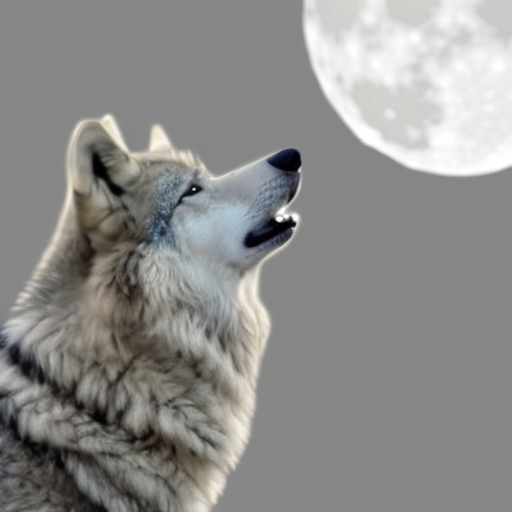

In [ ]:
display(make_image(image[0]))